# <center> Sweeping variables demonstration

### <center> In this demo you will sweep the amplitude of a pulse in loopback to demonstrate control over the QICK. 

We will sweep in two ways:
* Within the QICK assembly language (advantage: faster, disadvantage: does not maintain phase coherent readout)
* With a Python outer loop (advantage: maintains phase coherent readout, disadvantage: slower)

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.helpers import gauss
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc('../qick_lib/qick.bit')
# Set the loopback DAC channel to be in 1st Nyquist zone mode
soc.set_nyquist(ch=6,nqz=1); 

### Hardware Configuration

tProc channel 6   : DAC 229 CH3  <-> Readout channel 1 : ADC 224 CH1

In [3]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[adcfreq(self.cfg["pulse_freq"])]*2   #add frequency of adc ddc to config
        
        if self.cfg["pulse_style"] == "const":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["pulse_length"])  #add a constant pulse to the pulse library
        if self.cfg["pulse_style"] == "arb":
            self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], idata = self.cfg["idata"]) 
        
        freq=freq2reg(adcfreq(cfg["pulse_freq"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["pulse_gain"], t= 0, play=False) # pre-configure readout pulse
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        if self.cfg["pulse_style"] == "const":
            self.pulse(ch=self.cfg["res_ch"], length=self.cfg["pulse_length"], play=True) # play readout pulse
        if self.cfg["pulse_style"] == "arb":
            self.pulse(ch=self.cfg["res_ch"], play=True) # play readout pulse
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # sync all channels

In [4]:
class SweepProgram(RAveragerProgram):
    def __init__(self,cfg):
        AveragerProgram.__init__(self,cfg)

    def initialize(self):
        cfg=self.cfg   
        self.r_rp=self.ch_page(self.cfg["res_ch"])     # get register page for res_ch
        self.r_gain=self.sreg(cfg["res_ch"], "gain")   #Get gain register for res_ch
        
        r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[adcfreq(self.cfg["pulse_freq"])]*2   #add frequency of adc ddc to config
        
        self.add_pulse(ch=self.cfg["res_ch"], name="measure", style=self.cfg["pulse_style"], length=self.cfg["pulse_length"])  #add a constant pulse to the pulse library
        freq=freq2reg(adcfreq(cfg["pulse_freq"]))  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.pulse(ch=cfg["res_ch"], name="measure", freq=freq, phase=0, gain=cfg["start"], t= 0, play=False) # pre-configure readout pulse
#         self.synci(200)  # give processor some time to configure pulses
        self.sync_all(us2cycles(500))

    def body(self):        
        self.sync_all(us2cycles(0.05)) # align channels and wait 50ns
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"], length=self.cfg["pulse_length"], play=True) # play readout pulse
        self.sync_all(us2cycles(self.cfg["relax_delay"]))  # sync all channels
        self.synci(1000)
        
    def update(self):
        self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the pulse

### Sweeping via the QICK assembly language


In [5]:
config={"res_ch":6, # --Fixed
        "relax_delay":0, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "pulse_length":100, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":0, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "reps":50, 
        # New variables
        "expts": 20,
        "start":0, # [DAC units]
        "step":100 # [DAC units]
       }

prog =SweepProgram(config)
expt_pts, avg_di, avg_dq, avg_amp = prog.acquire(soc, load_pulses=True)

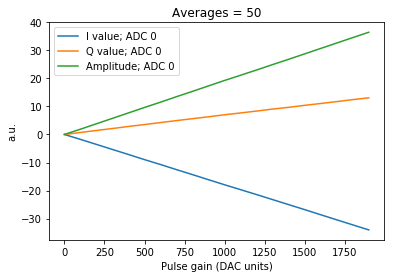

In [6]:
# Plot results.
plt.figure(1)
plt.plot(expt_pts, avg_di[1][0], label="I value; ADC 0")
plt.plot(expt_pts, avg_dq[1][0], label="Q value; ADC 0")
plt.plot(expt_pts, avg_amp[1][0], label="Amplitude; ADC 0")
# plt.plot(expt_pts, avg_di1, label="I value; ADC 1")
# plt.plot(expt_pts, avg_dq1, label="Q value; ADC 1")
# plt.plot(expt_pts, avg_amp1, label="Amplitude; ADC 1")
plt.ylabel("a.u.")
plt.xlabel("Pulse gain (DAC units)")
plt.title("Averages = " + str(config["reps"]))
plt.legend()
plt.savefig("images/Gain_sweep.pdf", dpi=350)

### Sweeping via a Python outer loop

In [7]:
config={"res_ch":6, # --Fixed
        "relax_delay":0, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "const", # --Fixed
        "pulse_length":100, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":0, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "reps":50, 
       }

prog =LoopbackProgram(config)
sweep_cfg={"start":0, "step":100, "expts":20}
gpts=sweep_cfg["start"] + sweep_cfg["step"]*np.arange(sweep_cfg["expts"])

prog =LoopbackProgram(config)
avg_di0, avg_dq0, avg_amp0,avg_di1, avg_dq1, avg_amp1 = prog.acquire(soc, load_pulses=True)
    
results=[]
for g in gpts:
    config["pulse_gain"]=int(g)
    prog =LoopbackProgram(config)
    results.append(prog.acquire(soc, load_pulses=True))
results=np.transpose(results)

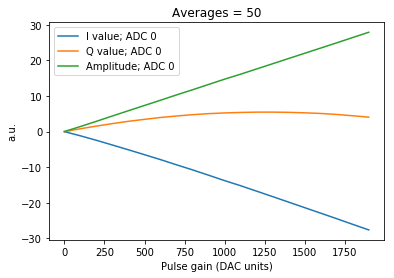

In [8]:
plt.figure(2)
plt.plot(gpts, results[3],label="I value; ADC 0")
plt.plot(gpts, results[4],label="Q value; ADC 0")
plt.plot(gpts, results[5],label="Amplitude; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Pulse gain (DAC units)")
plt.title("Averages = " + str(config["reps"]))
plt.legend()
plt.savefig("images/Gain_sweep_python.pdf", dpi=350)